In [4]:
pip install scikit-lego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklego.linear_model import LADRegression

In [6]:
train = pd.read_csv('../input/playground-series-s3e16/train.csv')
test = pd.read_csv('../input/playground-series-s3e16/test.csv')
original = pd.read_csv('../input/crab-age-prediction/CrabAgePrediction.csv')
submission = pd.read_csv('../input/playground-series-s3e16/sample_submission.csv')

print('The dimension of the train synthetic dataset is:', train.shape)
print('The dimension of the test synthetic dataset is:', test.shape)
print('The dimension of the orginal dataset is:', original.shape)
print('The dimension of the submission dataset is:', submission.shape)

The dimension of the train synthetic dataset is: (74051, 10)
The dimension of the test synthetic dataset is: (49368, 9)
The dimension of the orginal dataset is: (3893, 9)
The dimension of the submission dataset is: (49368, 2)


In [7]:
le = LabelEncoder()

train['generated'] = 1
original['generated'] = 0
test['generated'] = 1

train.drop(columns = 'id', axis = 1, inplace = True)

train = pd.concat([train, original], axis = 0).reset_index(drop = True)
train['Sex'] = le.fit_transform(train['Sex'])

In [8]:
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['Sex'] = le.transform(test_baseline['Sex'])

gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

In [37]:
a = sum(Y == 20)
print(a)

438


Next we proceed to build a couple of baseline models as shown below. Also, we ensemble the baseline model predictions using least absolute deviation regression.

In [ ]:
'''
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['Sex'] = le.transform(test_baseline['Sex'])

gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

skf = KFold(n_splits = 1, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ######################
    ## GradientBoosting ##
    ######################
        
    gb_md = GradientBoostingRegressor(loss = 'absolute_error',
                                      n_estimators = 1000, 
                                      max_depth = 8, 
                                      learning_rate = 0.01,
                                      min_samples_split = 10, 
                                      min_samples_leaf = 20).fit(X_train, Y_train) 
    
    gb_pred_1 = gb_md.predict(X_test[X_test['generated'] == 1])
    gb_pred_2 = gb_md.predict(test_baseline)
            
    gb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    
    print('Fold', i, '==> GradientBoositng oof MAE is ==>', gb_score_fold)
    
    
    ##########################
    ## HistGradientBoosting ##
    ##########################
        
    hist_md = HistGradientBoostingRegressor(loss = 'absolute_error',
                                            l2_regularization = 0.01,
                                            early_stopping = False,
                                            learning_rate = 0.01,
                                            max_iter = 1000,
                                            max_depth = 15,
                                            max_bins = 255,
                                            min_samples_leaf = 70,
                                            max_leaf_nodes = 115).fit(X_train, Y_train)
    
    hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
    hist_pred_2 = hist_md.predict(test_baseline)

    hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)
    
    print('Fold', i, '==> HistGradient oof MAE is ==>', hist_score_fold)
        
    ##############
    ## LightGBM ##
    ##############
        
    lgb_md = LGBMRegressor(objective = 'mae', 
                           n_estimators = 1000,
                           max_depth = 15,
                           learning_rate = 0.01,
                           num_leaves = 105,
                           reg_alpha = 8,
                           reg_lambda = 3,
                           subsample = 0.6,
                           colsample_bytree = 0.8,
                           device = 'gpu').fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
    lgb_pred_2 = lgb_md.predict(test_baseline)

    lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LightGBM oof MAE is ==>', lgb_score_fold)
        
    #############
    ## XGBoost ##
    #############
        
    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror',
                          tree_method = 'gpu_hist',
                          colsample_bytree = 0.9, 
                          gamma = 0.65, 
                          learning_rate = 0.01, 
                          max_depth = 7, 
                          min_child_weight = 20, 
                          n_estimators = 1000, 
                          subsample = 0.7).fit(X_train, Y_train)
    
    xgb_pred_1 = xgb_md.predict(X_test[X_test['generated'] == 1])
    xgb_pred_2 = xgb_md.predict(test_baseline)

    xgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i, '==> XGBoost oof MAE is ==>', xgb_score_fold)
    
    ##################
    ## LAD Ensemble ##
    ##################
    
    x = pd.DataFrame({'GBC':gb_pred_1,  'hist': hist_pred_1, 'lgb': lgb_pred_1, 'xgb': xgb_pred_1})
    y = Y_test[X_test['generated'] == 1]
    
    lad_md = LADRegression().fit(x, y)
    lad_pred = lad_md.predict(x)
    
    x_test = pd.DataFrame({'GBC':gb_pred_2,  'hist': hist_pred_2, 'lgb': lgb_pred_2, 'xgb': xgb_pred_2})
    lad_pred_test = lad_md.predict(x_test)
        
    ens_score = mean_absolute_error(y, lad_pred)
    ens_cv_scores.append(ens_score)
    ens_preds.append(lad_pred_test)
    
    print('Fold', i, '==> LAD ensemble oof MAE is ==>', ens_score)
'''

In [ ]:
'''
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
for i in [700,1000,1200]:
    for j in [8,10,12]:
        for k in [10,20,30,50]:
            for t in [10,20,30,50]:
                gb_md = GradientBoostingRegressor(loss = 'absolute_error',
                                                      n_estimators = i, 
                                                      max_depth = 8, 
                                                      learning_rate = 0.01,
                                                      min_samples_split = k, 
                                                      min_samples_leaf =t ).fit(X_train, Y_train) 
                gb_pred_1 = gb_md.predict(X_test[X_test['generated'] == 1])
                gb_pred_2 = gb_md.predict(test_baseline)

                gb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], gb_pred_1)
                gb_cv_scores.append(gb_score_fold)
                gb_preds.append(gb_pred_2)
                print('i=%d,j=%d,k=%d，t=%d,score=%.10f'%(i,j,k,t,gb_score_fold))
'''

In [ ]:
'''
for i in [500,700,1000,1200,1500]:
    for k in [50,70,100,120,150]:
        hist_md = HistGradientBoostingRegressor(loss = 'absolute_error',
                                                l2_regularization = 0.01,
                                                early_stopping = False,
                                                learning_rate = 0.01,
                                                max_iter = i,
                                                max_depth = 8,
                                                max_bins = 255,
                                                min_samples_leaf = k,
                                                max_leaf_nodes = k).fit(X_train, Y_train)

        hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
        hist_pred_2 = hist_md.predict(test_baseline)

        hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)
        hist_cv_scores.append(hist_score_fold)
        hist_preds.append(hist_pred_2)
        print('i=%d,k=%d，score=%.10f'%(i,k,hist_score_fold))
'''

In [ ]:
'''
for i in [500,700,1000,1200]:
    for k in [8,10,15]:
        for  j in [0.6,0.8,1]:
            for t in [0.8,1]:
                lgb_md = LGBMRegressor(objective = 'mae', 
                                           n_estimators = i,
                                           max_depth = k,
                                           learning_rate = 0.01,
                                           num_leaves = 105,
                                           reg_alpha = 8,
                                           reg_lambda = 3,
                                           subsample = j,
                                           colsample_bytree = t,
                                           device = 'gpu').fit(X_train, Y_train)

                lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
                lgb_pred_2 = lgb_md.predict(test_baseline)

                lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)    
                lgb_cv_scores.append(lgb_score_fold)
                lgb_preds.append(lgb_pred_2)
                print('i=%d,k=%d，j=%.2f,t=%.2f,score=%.10f'%(i,k,j,t,lgb_score_fold))
'''

In [ ]:
'''
for i in [0.8,0.9,1]:
    for j in[7,8,10,12]:
        for k in [200,800,1000,1200]:
            for t in [20,30,50]:
                for g in [0.7,0.8,0.9,1]:
                    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror',
                                              tree_method = 'gpu_hist',
                                              colsample_bytree = i, 
                                              gamma = 0.65, 
                                              learning_rate = 0.01, 
                                              max_depth = j, 
                                              min_child_weight = t, 
                                              n_estimators = k, 
                                              subsample = g).fit(X_train, Y_train)

                    xgb_pred_1 = xgb_md.predict(X_test[X_test['generated'] == 1])
                    xgb_pred_2 = xgb_md.predict(test_baseline)

                    xgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], xgb_pred_1)    
                    xgb_cv_scores.append(xgb_score_fold)
                    xgb_preds.append(xgb_pred_2)
                    print('i=%f,k=%d，j=%d,t=%d,g=%f,score=%.10f'%(i,k,j,t,g,xgb_score_fold))
'''

<a id="7"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

In this section, we improve baseline modeling 1.0 by adding a couple of engineered features and `CatBoost`. Notice that, a couple of the suggested engineered features from this [post](https://www.kaggle.com/competitions/playground-series-s3e16/discussion/415721).

In [9]:
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

X['Meat Yield'] = X['Shucked Weight'] / (X['Weight'] + X['Shell Weight'])
X['Shell Ratio'] = X['Shell Weight'] / X['Weight']
X['Weight_to_Shucked_Weight'] = X['Weight'] / X['Shucked Weight']
X['Viscera Ratio'] = X['Viscera Weight'] / X['Weight']

test_baseline = test.drop(columns = ['id'], axis = 1)

test_baseline['Sex'] = le.transform(test_baseline['Sex'])
test_baseline['Meat Yield'] = test_baseline['Shucked Weight'] / (test_baseline['Weight'] + test_baseline['Shell Weight'])
test_baseline['Shell Ratio'] = test_baseline['Shell Weight'] / test_baseline['Weight']
test_baseline['Weight_to_Shucked_Weight'] = test_baseline['Weight'] / test_baseline['Shucked Weight']
test_baseline['Viscera Ratio'] = test_baseline['Viscera Weight'] / test_baseline['Weight']

aml_cv_scores, aml_preds = list(), list()
gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
cat_cv_scores, cat_preds = list(), list()
ens_cv_scores_1, ens_preds_1 = list(), list()
ens_cv_scores_2, ens_preds_2 = list(), list()
ens_cv_scores_3, ens_preds_3 = list(), list()
ens_cv_scores_4, ens_preds_4 = list(), list()

In [30]:
print(X['Sex'])

0        1
1        1
2        2
3        0
4        1
        ..
77939    0
77940    0
77941    1
77942    1
77943    1
Name: Sex, Length: 77944, dtype: int64


In [13]:
mask = (Y <= 19) & (Y >= 4)
X_1 = X[mask]
Y_1 = Y[mask]

from sklearn.model_selection import train_test_split
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_1, Y_1, test_size=0.1, random_state=42)


xgb_md = XGBRegressor(objective = 'reg:pseudohubererror',
                          tree_method = 'hist',
                          colsample_bytree = 1, 
                          gamma = 0.65, 
                          learning_rate = 0.01, 
                          max_depth = 8, 
                          min_child_weight = 20, 
                          n_estimators = 1000,
                          subsample = 0.7,
                          random_state = 42).fit(X_train_gb, Y_train) 
    
X_train_gb_1 = X_train_1[gb_features]
X_test_gb_1 = X_test_1[gb_features]
test_baseline_gb = test_baseline[gb_features]
xgb_pred_1 = xgb_md.predict(X_test_gb_1[X_test_gb_1['generated'] == 1])


xgb_score_fold = mean_absolute_error(Y_test_1[X_test_gb_1['generated'] == 1], xgb_pred_1)    
xgb_score_fold_2 = mean_absolute_error(Y_test_1[X_test_gb_1['generated'] == 1], np.round(xgb_pred_1)) 


print(xgb_score_fold)
print(xgb_score_fold_2)

NameError: name 'X_train_gb' is not defined

In [16]:
X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

print('---------------------------------------------------------------')

######################
## GradientBoosting ##
######################

gb_features = ['Sex',
               'Length',
               'Diameter',
               'Height',
               'Weight',
               'Shucked Weight',
               'Viscera Weight',
               'Shell Weight',
               'generated']

X_train_gb = X_train[gb_features]
X_test_gb = X_test[gb_features]
test_baseline_gb = test_baseline[gb_features]

gb_md = GradientBoostingRegressor(loss = 'absolute_error',
                                  n_estimators = 1000, 
                                  max_depth = 8, 
                                  learning_rate = 0.01,
                                  min_samples_split = 10, 
                                  min_samples_leaf = 20,
                                  random_state = 42).fit(X_train_gb, Y_train) 

gb_pred_1 = gb_md.predict(X_test_gb[X_test_gb['generated'] == 1])
gb_pred_2 = gb_md.predict(test_baseline_gb)

gb_score_fold_1 = mean_absolute_error(Y_test[X_test_gb['generated'] == 1], gb_pred_1)
gb_score_fold_2 = mean_absolute_error(Y_test[X_test_gb['generated'] == 1], np.round(gb_pred_1))

gb_preds.append(gb_pred_2)
print(gb_score_fold_1)
print(gb_score_fold_2)
    #print('Fold', i, '==> GradientBoositng oof MAE is ==>', gb_score_fold)

---------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
print(max(gb_pred_2))
print(min(gb_pred_2))

In [15]:
skf = KFold(n_splits = 10, random_state = 42, shuffle = True)

for i, (train_ix, test_ix) in enumerate(skf.split(X_1, Y_1)):
    if i == 0:
        train_ix = train_ix
        test_ix = test_ix

In [15]:
print(max(gb_pred_1))
print(min(gb_pred_1))

18.984711392606197
3.6399331824323955


In [25]:
print(max(xgb_pred_1))
print(min(xgb_pred_1))

18.29166
3.773691


In [17]:
xgb_md = XGBRegressor(objective = 'reg:pseudohubererror',
                          tree_method = 'hist',
                          colsample_bytree = 1, 
                          gamma = 0.65, 
                          learning_rate = 0.01, 
                          max_depth = 8, 
                          min_child_weight = 20, 
                          n_estimators = 1000,
                          subsample = 0.7,
                          random_state = 42).fit(X_train_gb, Y_train) 
    
xgb_pred_1 = xgb_md.predict(X_test_gb[X_test_gb['generated'] == 1])


xgb_score_fold = mean_absolute_error(Y_test[X_test_gb['generated'] == 1], xgb_pred_1)    
xgb_score_fold_2 = mean_absolute_error(Y_test[X_test_gb['generated'] == 1], np.round(xgb_pred_1)) 


print(xgb_score_fold)
print(xgb_score_fold_2)

1.3531401612474645
1.3241602590044517


In [19]:
xgb_pred_2 = xgb_md.predict(test_baseline_gb)


In [20]:
print(max(xgb_pred_2))
print(min(xgb_pred_2))

19.812178
3.7428784


In [27]:
hist_md = HistGradientBoostingRegressor(loss = 'absolute_error',
                                            l2_regularization = 0.01,
                                            early_stopping = False,
                                            learning_rate = 0.01,
                                            max_iter = 1000,
                                            max_depth = 15,
                                            max_bins = 255,
                                            min_samples_leaf = 100,
                                            max_leaf_nodes = 70,
                                            random_state = 42).fit(X_train, Y_train) 
    
hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
hist_pred_2 = hist_md.predict(test_baseline)

hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)

print(max(hist_pred_1))
print(min(hist_pred_1))

18.281638491421948
3.9959701405784087


In [28]:
lgb_md = LGBMRegressor(objective = 'mae', 
                           n_estimators = 1200,
                           max_depth = 10,
                           learning_rate = 0.01,
                           num_leaves = 105, 
                           reg_alpha = 8, 
                           reg_lambda = 3, 
                           subsample = 0.8, 
                           colsample_bytree = 0.8,
                           random_state = 42).fit(X_train, Y_train)
    
lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
lgb_pred_2 = lgb_md.predict(test_baseline)

lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)    


print(max(lgb_pred_2))
print(min(lgb_pred_2))

18.74501251332373
3.9356159331343057


In [3]:
print(max(lgb_pred_2))
print(min(lgb_pred_2))

NameError: name 'lgb_pred_2' is not defined

In [29]:
'''
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

X['Meat Yield'] = X['Shucked Weight'] / (X['Weight'] + X['Shell Weight'])
X['Shell Ratio'] = X['Shell Weight'] / X['Weight']
X['Weight_to_Shucked_Weight'] = X['Weight'] / X['Shucked Weight']
X['Viscera Ratio'] = X['Viscera Weight'] / X['Weight']

test_baseline = test.drop(columns = ['id'], axis = 1)

test_baseline['Sex'] = le.transform(test_baseline['Sex'])
test_baseline['Meat Yield'] = test_baseline['Shucked Weight'] / (test_baseline['Weight'] + test_baseline['Shell Weight'])
test_baseline['Shell Ratio'] = test_baseline['Shell Weight'] / test_baseline['Weight']
test_baseline['Weight_to_Shucked_Weight'] = test_baseline['Weight'] / test_baseline['Shucked Weight']
test_baseline['Viscera Ratio'] = test_baseline['Viscera Weight'] / test_baseline['Weight']

aml_cv_scores, aml_preds = list(), list()
gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
cat_cv_scores, cat_preds = list(), list()
ens_cv_scores_1, ens_preds_1 = list(), list()
ens_cv_scores_2, ens_preds_2 = list(), list()
ens_cv_scores_3, ens_preds_3 = list(), list()
ens_cv_scores_4, ens_preds_4 = list(), list()
'''
skf = KFold(n_splits = 10, random_state = 42, shuffle = True)

for i, (train_ix, test_ix) in enumerate(skf.split(X_1, Y_1)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ######################
    ## GradientBoosting ##
    ######################
    
    gb_features = ['Sex',
                   'Length',
                   'Diameter',
                   'Height',
                   'Weight',
                   'Shucked Weight',
                   'Viscera Weight',
                   'Shell Weight',
                   'generated']
    
    X_train_gb = X_train[gb_features]
    X_test_gb = X_test[gb_features]
    test_baseline_gb = test_baseline[gb_features]
    
    gb_md = GradientBoostingRegressor(loss = 'absolute_error',
                                      n_estimators = 1000, 
                                      max_depth = 8, 
                                      learning_rate = 0.01,
                                      min_samples_split = 10, 
                                      min_samples_leaf = 20,
                                      random_state = 42).fit(X_train_gb, Y_train) 
    
    gb_pred_1 = gb_md.predict(X_test_gb[X_test_gb['generated'] == 1])
    gb_pred_2 = gb_md.predict(test_baseline_gb)
            
    gb_score_fold = mean_absolute_error(Y_test[X_test_gb['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    
    print('Fold', i, '==> GradientBoositng oof MAE is ==>', gb_score_fold)
    
    
    ##########################
    ## HistGradientBoosting ##
    ##########################
        
    hist_md = HistGradientBoostingRegressor(loss = 'absolute_error',
                                            l2_regularization = 0.01,
                                            early_stopping = False,
                                            learning_rate = 0.01,
                                            max_iter = 1000,
                                            max_depth = 15,
                                            max_bins = 255,
                                            min_samples_leaf = 100,
                                            max_leaf_nodes = 70,
                                            random_state = 42).fit(X_train, Y_train) 
    
    hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
    hist_pred_2 = hist_md.predict(test_baseline)

    hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)
    
    print('Fold', i, '==> HistGradient oof MAE is ==>', hist_score_fold)
        
    ##############
    ## LightGBM ##
    ##############
        
    lgb_md = LGBMRegressor(objective = 'mae', 
                           n_estimators = 1200,
                           max_depth = 10,
                           learning_rate = 0.01,
                           num_leaves = 105, 
                           reg_alpha = 8, 
                           reg_lambda = 3, 
                           subsample = 0.8, 
                           colsample_bytree = 0.8,
                           random_state = 42).fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
    lgb_pred_2 = lgb_md.predict(test_baseline)

    lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LightGBM oof MAE is ==>', lgb_score_fold)
        
    #############
    ## XGBoost ##
    #############
    
    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror',
                          tree_method = 'hist',
                          colsample_bytree = 1, 
                          gamma = 0.65, 
                          learning_rate = 0.01, 
                          max_depth = 8, 
                          min_child_weight = 20, 
                          n_estimators = 1000,
                          subsample = 0.7,
                          random_state = 42).fit(X_train_gb, Y_train) 
    
    xgb_pred_1 = xgb_md.predict(X_test_gb[X_test_gb['generated'] == 1])
    xgb_pred_2 = xgb_md.predict(test_baseline_gb)

    xgb_score_fold = mean_absolute_error(Y_test[X_test_gb['generated'] == 1], xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i, '==> XGBoost oof MAE is ==>', xgb_score_fold)
    
    
    
   
    
    
    ##################
    ## LAD Ensemble ##
    ##################
    
    x = pd.DataFrame({'GBC': np.round(gb_pred_1.tolist()),  'hist': np.round(hist_pred_1.tolist()), 
                      'lgb': np.round(lgb_pred_1.tolist()), 'xgb': np.round(xgb_pred_1.tolist())
                      })
    y = Y_test[X_test['generated'] == 1]
    
    x_test = pd.DataFrame({'GBC': np.round(gb_pred_2.tolist()),  'hist': np.round(hist_pred_2.tolist()), 
                           'lgb': np.round(lgb_pred_2.tolist()), 'xgb': np.round(xgb_pred_2.tolist()), 
                           })
    
    lad_md_1 = LADRegression(fit_intercept = True, positive = False).fit(x, y)
    lad_md_2 = LADRegression(fit_intercept = True, positive = True).fit(x, y)
    lad_md_3 = LADRegression(fit_intercept = False, positive = True).fit(x, y)
    lad_md_4 = LADRegression(fit_intercept = False, positive = False).fit(x, y)
    
    lad_pred_1 = lad_md_1.predict(x)
    lad_pred_2 = lad_md_2.predict(x)
    lad_pred_3 = lad_md_3.predict(x)
    lad_pred_4 = lad_md_4.predict(x)
    
    lad_pred_test_1 = lad_md_1.predict(x_test)
    lad_pred_test_2 = lad_md_2.predict(x_test)
    lad_pred_test_3 = lad_md_3.predict(x_test)
    lad_pred_test_4 = lad_md_4.predict(x_test)
        
    ens_score_1 = mean_absolute_error(y, lad_pred_1)
    ens_cv_scores_1.append(ens_score_1)
    ens_preds_1.append(lad_pred_test_1)
    
    ens_score_2 = mean_absolute_error(y, lad_pred_2)
    ens_cv_scores_2.append(ens_score_2)
    ens_preds_2.append(lad_pred_test_2)
    
    ens_score_3 = mean_absolute_error(y, lad_pred_3)
    ens_cv_scores_3.append(ens_score_3)
    ens_preds_3.append(lad_pred_test_3)
    
    ens_score_4 = mean_absolute_error(y, lad_pred_4)
    ens_cv_scores_4.append(ens_score_4)
    ens_preds_4.append(lad_pred_test_4)
    
    print('Fold', i, '==> LAD Model 1 ensemble oof MAE is ==>', ens_score_1)
    print('Fold', i, '==> LAD Model 2 ensemble oof MAE is ==>', ens_score_2)
    print('Fold', i, '==> LAD Model 3 ensemble oof MAE is ==>', ens_score_3)
    print('Fold', i, '==> LAD Model 4 ensemble oof MAE is ==>', ens_score_4)


---------------------------------------------------------------
Fold 0 ==> GradientBoositng oof MAE is ==> 1.3489326058430415
Fold 0 ==> HistGradient oof MAE is ==> 1.3440783564302452
Fold 0 ==> LightGBM oof MAE is ==> 1.3419025703311969
Fold 0 ==> XGBoost oof MAE is ==> 1.3543843457756033
Fold 0 ==> LAD Model 1 ensemble oof MAE is ==> 1.3250202212355822
Fold 0 ==> LAD Model 2 ensemble oof MAE is ==> 1.325020221123636
Fold 0 ==> LAD Model 3 ensemble oof MAE is ==> 1.3250202210838566
Fold 0 ==> LAD Model 4 ensemble oof MAE is ==> 1.325020221499828
---------------------------------------------------------------
Fold 1 ==> GradientBoositng oof MAE is ==> 1.3826250183449893
Fold 1 ==> HistGradient oof MAE is ==> 1.3862933073112091
Fold 1 ==> LightGBM oof MAE is ==> 1.379667057932577
Fold 1 ==> XGBoost oof MAE is ==> 1.3912427103448826
Fold 1 ==> LAD Model 1 ensemble oof MAE is ==> 1.3637587517438314
Fold 1 ==> LAD Model 2 ensemble oof MAE is ==> 1.3637587506734392
Fold 1 ==> LAD Model 3 en

In [22]:
gb_cv_scores=[1.3489326058430415,1.3415450901897583,1.3376154480249014,1.3681204994107228,1.4024483046587237,1.3604542721121695,1.3180850740920165,1.332932997141231,1.3606749919092713,1.3826250183449893]

In [23]:
print(np.mean(gb_cv_scores))

1.3553434301726823


In [24]:
hist_cv_scores = [1.347358828112607,1.334987423713544,1.37487333166954,1.4049214080845345,1.3561922326926876,1.312352170627065,1.3344126156111404,1.3619033367201194,1.3862933073112091,1.3440783564302452]

In [25]:
print(np.mean(hist_cv_scores))

1.3557373010972693


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


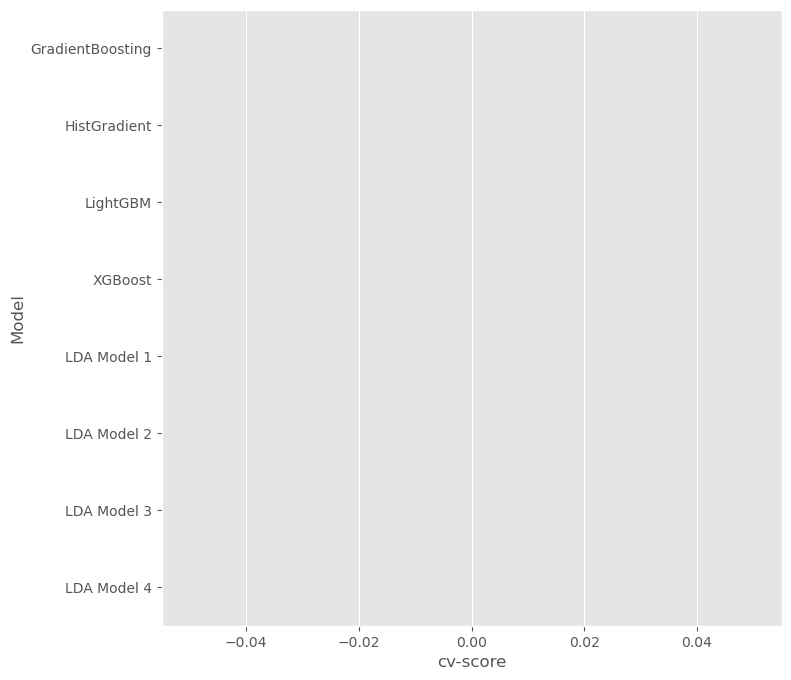

In [21]:
gb_cv_score = np.mean(gb_cv_scores)
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
ens_cv_score_1 = np.mean(ens_cv_scores_1)
ens_cv_score_2 = np.mean(ens_cv_scores_2)
ens_cv_score_3 = np.mean(ens_cv_scores_3)
ens_cv_score_4 = np.mean(ens_cv_scores_4)

model_perf = pd.DataFrame({'Model': ['GradientBoosting', 'HistGradient' ,'LightGBM', 'XGBoost', 
                                     'LDA Model 1',
                                     'LDA Model 2',
                                     'LDA Model 3',
                                     'LDA Model 4'],
                           'cv-score': [gb_cv_score, hist_cv_score, lgb_cv_score, xgb_cv_score, 
                                        ens_cv_score_1,
                                        ens_cv_score_2,
                                        ens_cv_score_3,
                                        ens_cv_score_4]})

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'cv-score', data = model_perf)
ax.bar_label(ax.containers[0]);

In [ ]:
ens_preds_test_1 = pd.DataFrame(ens_preds_1).apply(np.mean, axis = 0)
ens_preds_test_2 = pd.DataFrame(ens_preds_2).apply(np.mean, axis = 0)
ens_preds_test_3 = pd.DataFrame(ens_preds_3).apply(np.mean, axis = 0)
ens_preds_test_4 = pd.DataFrame(ens_preds_4).apply(np.mean, axis = 0)

submission['Age'] = round(ens_preds_test_1).astype(int)
submission.to_csv('LAD_Ensemble_model_1.csv', index = False)

submission['Age'] = round(ens_preds_test_2).astype(int)
submission.to_csv('LAD_Ensemble_model_2.csv', index = False)

submission['Age'] = round(ens_preds_test_3).astype(int)
submission.to_csv('LAD_Ensemble_model_3.csv', index = False)

submission['Age'] = round(ens_preds_test_4).astype(int)
submission.to_csv('LAD_Ensemble_model_4.csv', index = False)